In [131]:
# If external python files are updated
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, recall_score

import torch.nn.init as init
from torch.optim import lr_scheduler

import functions
from functions import Custom_DNN, EarlyStopper

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device used: cpu


In [132]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [133]:
train_size = 0.75                     # In percent
test_size = 1 - train_size           # In percent, calculated dynamically from train_size
batch_size = 16                      # Size of batches

In [134]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for path in folder_paths:
    c = folder_paths.index(path)
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy arrayF
X = np.array(X)

from sklearn.preprocessing import Normalizer

# Transpose to make each image a row
X = X.reshape(X.shape[0], -1)

# Normalize each row (i.e., each flattened image)
X = Normalizer().fit_transform(X)
X = X.reshape(len(X), 128**2)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

# Shape of the array
print(np.shape(X))

(6400, 16384)


In [135]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1 - train_size, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1 - train_size, stratify=Y_train, random_state=42)

for i in np.unique(Y_train):
    print(f"Elements of {i} in X_train: {np.count_nonzero(Y_train == i)}")
print()
for i in np.unique(Y_test):
    print(f"Elements of {i} in X_test: {np.count_nonzero(Y_test == i)}")
print()
for i in np.unique(Y_val):
    print(f"Elements of {i} in X_val: {np.count_nonzero(Y_val == i)}")

Elements of 0 in X_train: 1800
Elements of 1 in X_train: 1260
Elements of 2 in X_train: 504
Elements of 3 in X_train: 36

Elements of 0 in X_test: 800
Elements of 1 in X_test: 560
Elements of 2 in X_test: 224
Elements of 3 in X_test: 16

Elements of 0 in X_val: 600
Elements of 1 in X_val: 420
Elements of 2 in X_val: 168
Elements of 3 in X_val: 12


In [136]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data_point = self.X[idx]
        label = self.Y[idx]

        if self.transform:
            data_point = self.transform(data_point)
        
        data_point = torch.tensor(data_point, dtype=torch.float32)

        return data_point, label

transformation = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])

# Create an instance of your dataset
dataset_train = MyDataset(X=X_train, Y=Y_train, transform=transformation)
dataset_val = MyDataset(X=X_val, Y=Y_val, transform=transformation)
dataset_test = MyDataset(X=X_test, Y=Y_test, transform=transformation)

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Dynamic DNN creation

In [137]:
# Example usage of dense neural network

# First define criterion
# criterion = functions.FocalLoss()
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

# Define instance of model and initialize the weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

dynamic_model = Custom_DNN(input_size=128**2, initial_nodes=256, output_size=4, n_layers=4, operation_and_factor= ('/', 4), dropout_rate=0.2, evaluation_metrics = metrics)
dynamic_model.apply(init_weights)

# Now define the loss (criterion), optimizer, lr_scheduler, 
early_stopper = EarlyStopper(dynamic_model, patience=3, min_delta=0)
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Now use the training function to train the network
functions.train_network(dynamic_model, train_loader, criterion, optimizer, 2, scheduler, validation_loader, device, early_stopper)

Device used for training: cpu
Epoch [1/2]  loss: 1.2725, acc: 0.5208, macro recall: 0.2676
Epoch [2/2]  loss: 1.2309, acc: 0.5375, macro recall: 0.2954


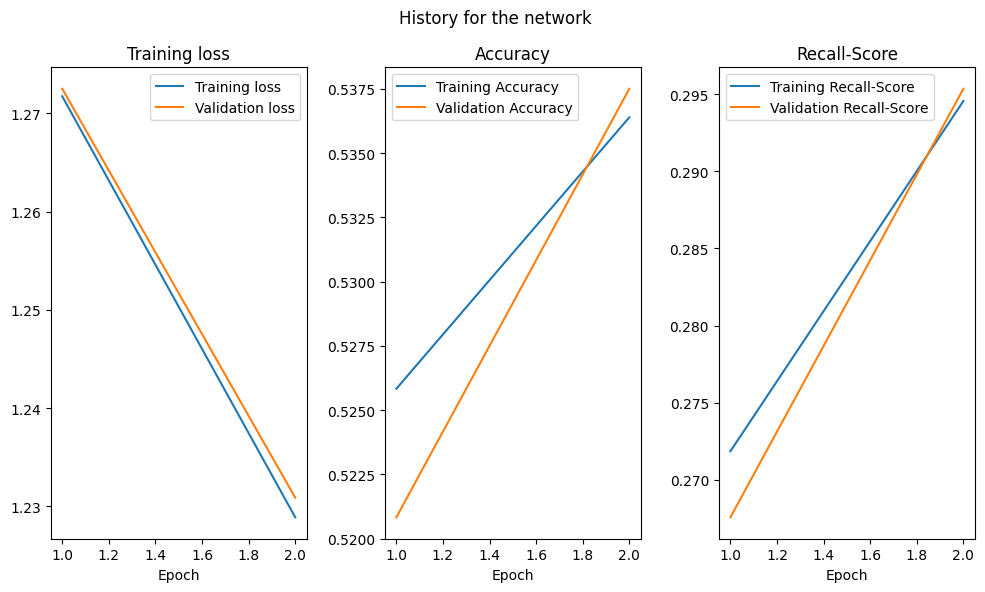

In [138]:
loss_training_hist = dynamic_model.history['loss']
training_acc_hist = dynamic_model.history['acc']
training_w_recall_hist = dynamic_model.history['macro recall']
loss_val_hist = dynamic_model.history_validation['loss']
val_acc_hist = dynamic_model.history_validation['acc']
val_w_recall_hist = dynamic_model.history_validation['macro recall']

x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

ax[2].plot(x_epochs, training_w_recall_hist, label='Training Recall-Score')
ax[2].plot(x_epochs, val_w_recall_hist, label='Validation Recall-Score')
ax[2].set(
    xlabel='Epoch',
    title = 'Recall-Score',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.tight_layout()
plt.show()

In [139]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred, y_true = dynamic_model.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.57      0.83      0.68       800
           1       0.41      0.33      0.36       560
           2       0.00      0.00      0.00       224
           3       0.00      0.00      0.00        16

    accuracy                           0.53      1600
   macro avg       0.25      0.29      0.26      1600
weighted avg       0.43      0.53      0.47      1600



c:\Users\benji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [28]:
test_model = torch.load('test_model.pth')

y_pred, y_true = test_model.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       800
           1       0.60      0.56      0.58       560
           2       0.72      0.58      0.65       224
           3       0.00      0.00      0.00        16

    accuracy                           0.69      1600
   macro avg       0.52      0.49      0.50      1600
weighted avg       0.68      0.69      0.68      1600



/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [59]:
np.count_nonzero(y_true[y_true == 3])

1

In [57]:
confusion_matrix(y_true, y_cls)

array([[663, 131,   6,   0],
       [218, 313,  29,   0],
       [ 13,  80, 131,   0],
       [  0,   1,  15,   0]])

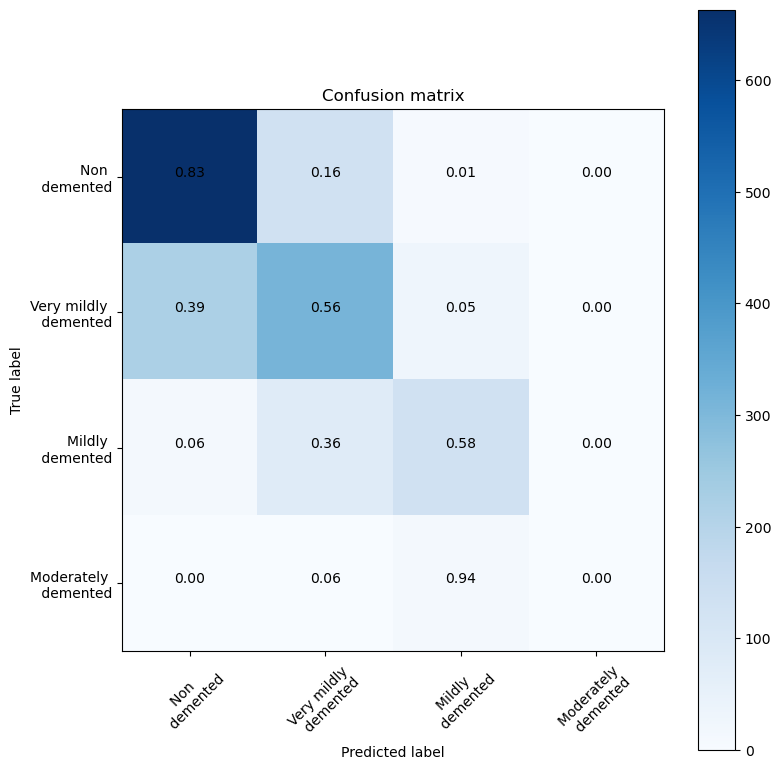

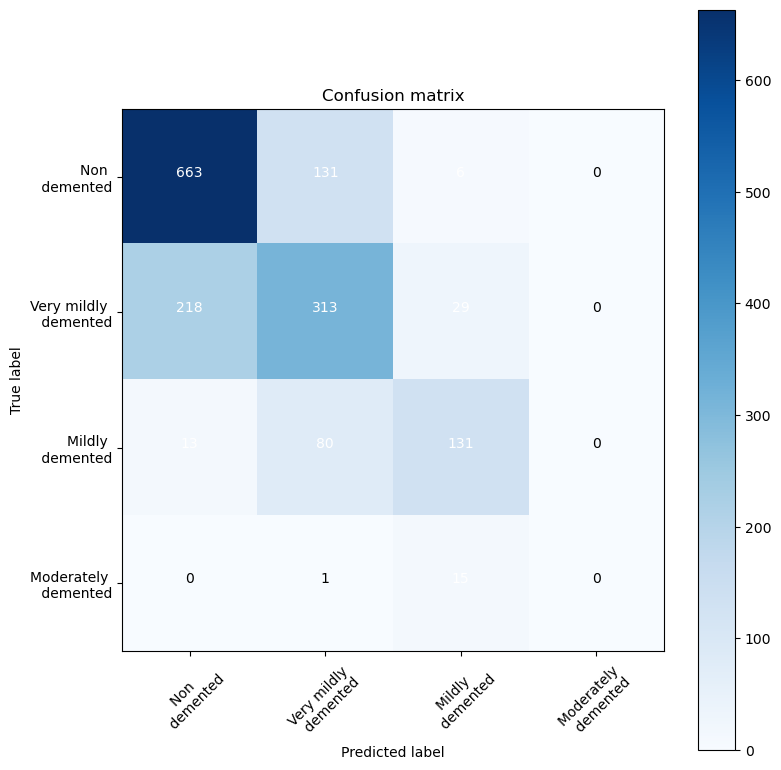

In [70]:
#Note, this code is taken straight from the SKLEARN website, a nice way of viewing confusion matrix.
import itertools
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    thresh = 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = confusion_matrix(y_true, y_cls)
# plot the confusion matrix

labels = ['Non \n demented', 'Very mildly \n demented', 'Mildly \n demented', 'Moderately \n demented']

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_mtx, classes = labels)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

# Hyperparameter search

In [140]:
from itertools import product
import joblib

params_to_test = ({
    'num_dense_layers' : [2, 4],
    'num_dense_nodes' : [512, 2048, 8192],
    'factor' : [2, 3],
})

value_combis = product(*[v for v in params_to_test.values()])

hyperparameter_combinations = []
for combi in value_combis:
  hyperparameter_combinations.append({key: value for key, value in zip(params_to_test.keys(), combi)})

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

# Hyperparameters, which are not tested
epochs = 50
dropout_rate = 0.15
        
# Define lists to store the histories and the corresponding parameters in
hist_loss_params = {}

# Define the metrics to monitor during training and save them in a dict
criterion = nn.CrossEntropyLoss()

def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))

def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)

def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')

metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

smallest_loss = np.inf

# Print the generated combinations
for i, params in enumerate(hyperparameter_combinations):
    # Define model
    test_model = Custom_DNN(128**2, params['num_dense_nodes'], num_classes, params['num_dense_layers'], ('/', params['factor']), dropout_rate=dropout_rate, evaluation_metrics=metrics)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    functions.train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)
    # Get history
    loss_training_hist, acc_training_hist, macro_recall_training_hist = test_model.history['loss'], test_model.history['acc'], test_model.history['macro recall']
    loss_validation_hist, acc_validation_hist, macro_recall_validation_hist = test_model.history['loss'], test_model.history_validation['acc'], test_model.history_validation['macro recall']
    # Store the hists etc
    hist_loss_params[tuple(params.items())] = (loss_training_hist, acc_training_hist, macro_recall_training_hist, loss_validation_hist, acc_validation_hist, macro_recall_validation_hist)

    if loss_validation_hist[-1] < smallest_loss:
        joblib.dump(test_model, 'best_dnn.pkl')
        smallest_loss = loss_validation_hist[-1]

Size last layer before output: 512
Device used for training: cpu
Epoch [1/50]  loss: 1.2090, acc: 0.5000, macro recall: 0.2500
Epoch [2/50]  loss: 1.2187, acc: 0.5725, macro recall: 0.3355
Epoch [3/50]  loss: 1.1966, acc: 0.5258, macro recall: 0.2731
Epoch [4/50]  loss: 1.2241, acc: 0.5567, macro recall: 0.3415
Epoch [5/50]  loss: 1.2137, acc: 0.5808, macro recall: 0.3476
Epoch [6/50]  loss: 1.1791, acc: 0.5992, macro recall: 0.3542
Epoch [7/50]  loss: 1.1557, acc: 0.5942, macro recall: 0.3398
Epoch [8/50]  loss: 1.1592, acc: 0.6200, macro recall: 0.3698
Epoch [9/50]  loss: 1.1447, acc: 0.5858, macro recall: 0.3754
Epoch [10/50]  loss: 1.1642, acc: 0.6233, macro recall: 0.3767
Epoch [11/50]  loss: 1.1294, acc: 0.6408, macro recall: 0.4004
Epoch [12/50]  loss: 1.1534, acc: 0.6175, macro recall: 0.4659
Epoch [13/50]  loss: 1.1197, acc: 0.6733, macro recall: 0.6445
Epoch [14/50]  loss: 1.0899, acc: 0.6783, macro recall: 0.6077
Epoch [15/50]  loss: 1.0673, acc: 0.7167, macro recall: 0.6794

In [141]:
print(test_model)
y_pred, y_true = test_model.evaluate(test_loader)
#Display weights of one layer
print(test_model.linears[0].weight)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_cls))
joblib.dump(test_model, 'best_dnn.pkl')


loaded_model = joblib.load('best_dnn.pkl')
print(loaded_model)
y_pred, y_true = loaded_model.evaluate(test_loader)
print(loaded_model.linears[0].weight)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_cls))

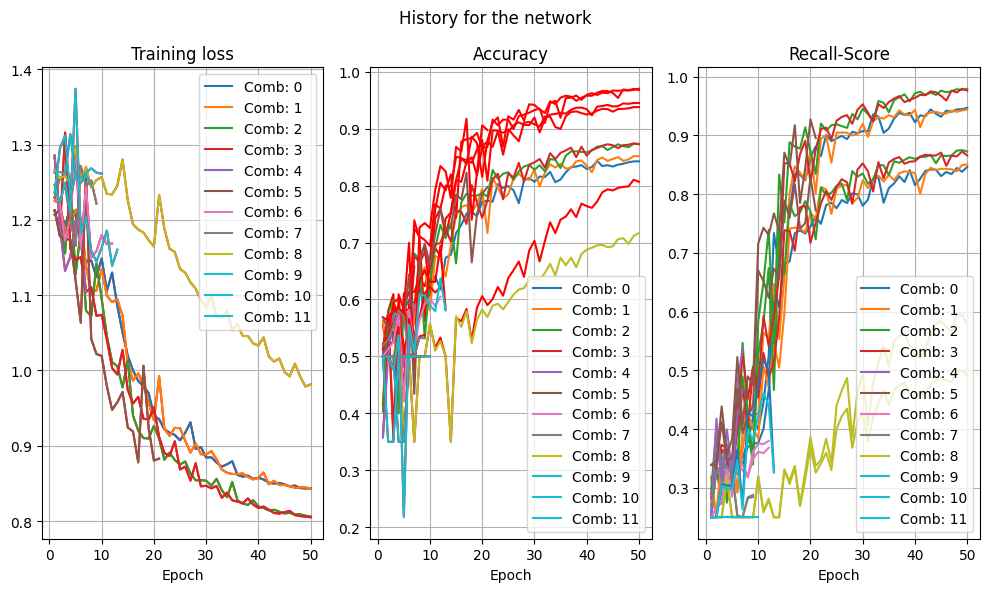

In [142]:
from itertools import cycle

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].set(
    xlabel='Epoch',
    title='Training loss',
)
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)
ax[2].set(
    xlabel='Epoch',
    title = 'Recall-Score',
)

color_cycle = plt.cm.tab10(np.arange(len(hyperparameter_combinations)))
# Create a cycle iterator for colors
color_iter = cycle(color_cycle)

for i, params in enumerate(hyperparameter_combinations):
    color = next(color_iter)
    (loss_training_hist, acc_training_hist, macro_recall_training_hist, loss_validation_hist, acc_validation_hist, macro_recall_validation_hist) = hist_loss_params[tuple(params.items())]
    x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
    # Loss
    ax[0].plot(x_epochs, loss_training_hist, c = 'r')
    ax[0].plot(x_epochs, loss_validation_hist, label = f'Comb: {i}', c = color)
    # Acc
    ax[1].plot(x_epochs, acc_training_hist, c = 'r')
    ax[1].plot(x_epochs, acc_validation_hist, label = f'Comb: {i}', c = color)
    # Acc
    ax[2].plot(x_epochs, macro_recall_training_hist)
    ax[2].plot(x_epochs, macro_recall_validation_hist, label = f'Comb: {i}', c = color)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
ax[0].grid(':')
ax[1].grid(':')
ax[2].grid(':')
plt.tight_layout()
plt.show() 